In [1]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
### Import the dataset & divide as training, validation & testing
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, Sequential, utils
from tensorflow.keras import activations,applications, optimizers
import tensorflow_addons as tfa


### Model Hyper-Parameters
IMG_SIZE = 72
PATCH_SIZE = 6
BATCH_SIZE = 256
PATCH_PROJECTION_SIZE = 64
NUM_ATTENTION_HEADS = 4
NUM_TRANSFORMER_BLOCKS = 8
EPOCHS = 100


### Calculated Model Parameters
Number_Of_PATCHES = (IMG_SIZE//PATCH_SIZE) ** 2  # Floor Division

Number_Of_Classes = None

(train_ds, val_ds, test_ds), metadata = tfds.load(
    'cifar100',
    split=['train','test[:50%]','test[50%:]'],
    with_info=True,
    as_supervised=True,
    shuffle_files=True
)

Number_Of_Classes = metadata.features['label'].num_classes


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incomplete6UFRN1/cifar100-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incomplete6UFRN1/cifar100-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.


In [5]:
### Preprocessing: Normalize the image size & channel values to be 0==>1
resize_and_scale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

def preprocess(ds,BATCH_SIZE):
  ds = ds.map(lambda image, label: (resize_and_scale(image), label))
  ds = ds.batch(BATCH_SIZE)
  return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds = preprocess(train_ds,BATCH_SIZE)
val_ds = preprocess(val_ds,BATCH_SIZE)
test_ds = preprocess(test_ds,BATCH_SIZE)

def resultPlot(history,epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='center right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [8]:
### Build Custom Layers needed for the transformer model

### 1. Patch Extraction layer
# divide the input image (W*W*C) into 2-D patches (P*P*C), flatten each patch to (C*P^2) vector 
class extractPatchesLayer (layers.Layer):
    def __init__(self, image_size, patch_size):
        super(extractPatchesLayer, self).__init__()
        self.patch_size = patch_size
        self.image_size = image_size

    def call(self, images):
        #batch_size = tf.shape(images)[0]
        # Valid means only consider patches which are fully contained in the image
        patches = tf.image.extract_patches( 
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID")
        patch_dimension = patches.shape[-1]

        # fatten & keep the same batch size
        # (-1) dimension means auto compute that dimension to fulfill
        # other dimensions
        numberOfPatches = (self.image_size//self.patch_size)**2
        patches = tf.reshape(patches, [-1,numberOfPatches , patch_dimension])
        return patches

### 2. Patch Embedding layer
# Apply learnable linear transformation to map each patch (P^2 vector) to a new (D vector) using a dense-layer
class embedPatchesLayer (layers.Layer):
    def __init__(self, targetPatchDimension):
        super(embedPatchesLayer, self).__init__()
        self.projection = layers.Dense(units=targetPatchDimension)
    def call(self, patches):
        embeddedPatches = self.projection(patches)
        return embeddedPatches

### 3. Add learnble CLS (Classification) vector to the start of the sequence of embedded patches
class addCLSTokenLayer (layers.Layer):
    def __init__(self,batchSize,projectionDimension):
        super(addCLSTokenLayer, self).__init__()
        #self.batchSize = batchSize
        self.projectionDimension = projectionDimension

        # CLS class embedding is just a learnable variable of size D
        self.CLS = self.add_weight("CLS", shape=(1, 1, self.projectionDimension))  
              
    def call(self, embeddedPatches):
        # broadcast (repeat the same vector) for all batches (same learnable variable)
        batch_size = tf.shape(embeddedPatches)[0]
        CLS = tf.broadcast_to(self.CLS, [batch_size, 1, self.projectionDimension])        
        embeddedPatches = tf.concat([CLS, embeddedPatches], axis=1)
        return embeddedPatches

### 4. Add Position Embedding layer
# Add position embedding to each embedded patch
class embedPositionLayer (layers.Layer):
    def __init__(self,numOfPatches,projectionDimension):
        super(embedPositionLayer, self).__init__()
        self.numOfPatches = numOfPatches
        self.projectionDimension = projectionDimension
        self.positions = tf.range(start=0, limit=self.numOfPatches, delta=1)
        self.position_embedding = layers.Embedding(
        input_dim=self.numOfPatches, output_dim=self.projectionDimension)(self.positions)
    def call(self, embeddedPatches):
        encodedPatches = embeddedPatches + self.position_embedding
        return encodedPatches

### 5. Transformer Block layer
### NOTE: You need to declaer the layers inside the init & use
### within the call or oterwise it will not be counted in model parameters
class transformerBlockLayer (layers.Layer):
    def __init__(self,num_heads,key_dim):
        super(transformerBlockLayer, self).__init__()
        self.layerNorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layerNorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.multiHeadAttenLayer = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=key_dim,dropout=0.1)
        self.dense1 = layers.Dense(units=key_dim*2, activation=tf.nn.gelu)
        self.dense2 = layers.Dense(units=key_dim, activation=tf.nn.gelu)
        self.dropout1 = layers.Dropout(0.1)
        self.dropout2 = layers.Dropout(0.1)
        
    def call(self, x):
        # Layer normalization 1
        x1 = self.layerNorm1(x)
        # Multi-head attention layer
        x1 = self.multiHeadAttenLayer(x1, x1)
        # Skip connection 1
        x = layers.Add()([x, x1])

        # MLP layer
        x1 = self.layerNorm2(x)
        x1 = self.dense1(x1)
        x1 = self.dropout1(x1)
        x1 = self.dense2(x1)
        x1 = self.dropout2(x1)
        # Skip connection 2
        output = layers.Add()([x, x1])
        return output

### 6. Classification Head
class classificationHead (layers.Layer):
    def __init__(self,num_classes):
        super(classificationHead, self).__init__()
        self.dense0 = layers.Dense(units=2048, activation=tf.nn.gelu)
        self.dense1 = layers.Dense(units=1024, activation=tf.nn.gelu)
        self.dense2 = layers.Dense(num_classes)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self,x):
      x = x[:, 0]
      x = self.dense0(x)
      x = self.dropout1(x)      
      x = self.dense1(x)
      x = self.dropout2(x)
      x = self.dense2(x)
      return  x  


In [9]:
### Build the Transformer Encoder Inputs (sequence of encoded patches with position embeddings)

# 1. Data Augmentation layers
input = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
x = layers.Normalization()(input)
x = layers.RandomFlip("horizontal")(x)
x = layers.RandomRotation(factor=0.02)(x)
x = layers.RandomZoom(height_factor=0.2, width_factor=0.2)(x)

# 2. Extract Patches layer
x = extractPatchesLayer(IMG_SIZE,PATCH_SIZE)(x)

# 3. Project Patches to the transformer input vector dimension
x = embedPatchesLayer(PATCH_PROJECTION_SIZE)(x)

# 4. Add CLS vector to the beging of the sequence of embedded patches
x = addCLSTokenLayer(BATCH_SIZE,PATCH_PROJECTION_SIZE)(x)

# 5. Add position embedding to the input sequence
x = embedPositionLayer(Number_Of_PATCHES+1,PATCH_PROJECTION_SIZE)(x)

# 6. Apply transformer blocks
# I needed to rewrite the transformer block code, check the nte there
for _ in range(NUM_TRANSFORMER_BLOCKS):
  x = transformerBlockLayer(NUM_ATTENTION_HEADS,PATCH_PROJECTION_SIZE)(x)

# 7. Add classification head
output = classificationHead(Number_Of_Classes)(x)


model = tf.keras.Model(input, output)
model.summary(expand_nested=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 72, 72, 3)]       0         
                                                                 
 normalization (Normalizatio  (None, 72, 72, 3)        7         
 n)                                                              
                                                                 
 random_flip (RandomFlip)    (None, 72, 72, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 72, 72, 3)        0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 72, 72, 3)         0         
                                                                 
 extract_patches_layer (extr  (None, 144, 108)         0     

1/1 [==============================] - 30s 30s/step - loss: 2.1419 - accuracy: 0.4414
Epoch 56/60
196/196 [==============================] - 2809s 14s/step - loss: 2.0634 - accuracy: 0.4459 - val_loss: 2.3024 - val_accuracy: 0.4078
Epoch 57/60
196/196 [==============================] - 2789s 14s/step - loss: 2.0699 - accuracy: 0.4452 - val_loss: 2.3066 - val_accuracy: 0.4092
Epoch 58/60
196/196 [==============================] - 2771s 14s/step - loss: 2.0765 - accuracy: 0.4433 - val_loss: 2.3027 - val_accuracy: 0.4080
Epoch 59/60
196/196 [==============================] - 2771s 14s/step - loss: 2.0814 - accuracy: 0.4413 - val_loss: 2.3134 - val_accuracy: 0.4034
Epoch 60/60
196/196 [==============================] - 2769s 14s/step - loss: 2.0872 - accuracy: 0.4384 - val_loss: 2.3020 - val_accuracy: 0.4098


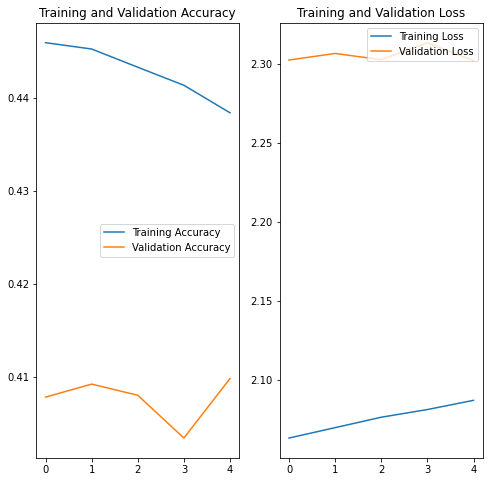

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ColabModels/Transformer-Model-CIFAR100/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ColabModels/Transformer-Model-CIFAR100/assets


In [11]:
### Training the model
learning_rate = 0.0001
weight_decay = 0.0001
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
#optimizer = tf.optimizers.SGD(learning_rate=learning_rate)


#early_stop = tf.keras.callbacks.EarlyStopping('val_accuracy', patience=10)
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau('val_accuracy', factor=0.5, patience=5,min_lr=0.00001,verbose=1)
checkpoint_filepath='/content/drive/MyDrive/ColabModels/Transformer-CIFAR100.Run12-epoch{epoch:02d}-val_loss{val_loss:.2f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
#callbacks = [ early_stop, reduce_lr,model_checkpoint_callback]
callbacks = [model_checkpoint_callback]


model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### warm up (build the computational graph in order to load the weights and optimizer status)
history = model.fit(train_ds,epochs=1,steps_per_epoch=1)


### Load model weights from last runs
model.load_weights('/content/drive/MyDrive/ColabModels/Transformer-CIFAR100.Run11-epoch55-val_loss2.29.h5')

### Load optimizer status from last run
import pickle
with open('/content/drive/MyDrive/ColabModels/optimizer_Run11.pkl', 'rb') as f:
    weight_values = pickle.load(f)
model.optimizer.set_weights(weight_values)


### Continue Training based on last run
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=60,
  callbacks=callbacks,
  initial_epoch=55)

actual_number_of_epochs = len(history.history['loss'])
resultPlot(history,actual_number_of_epochs)



### Save Optimizer Status
symbolic_weights = getattr(model.optimizer, 'weights')
weight_values = tf.keras.backend.batch_get_value(symbolic_weights)
with open('/content/drive/MyDrive/ColabModels/optimizer_Run12.pkl', 'wb') as f:
    pickle.dump(weight_values, f)

### save model executables
model.save('/content/drive/MyDrive/ColabModels/Transformer-Model-CIFAR100')

In [6]:
### Evaluating the model
model_test=tf.keras.models.load_model('/content/drive/MyDrive/ColabModels/Transformer-Model-CIFAR100')
print("Evaluate on test data")
results_test = model_test.evaluate(test_ds)


Evaluate on test data
20/20 [==============================] - 95s 5s/step - loss: 2.3239 - accuracy: 0.4064
